In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, categorical_dim, feature_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, categorical_dim * feature_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

# Decoder
class Decoder(nn.Module):
    def __init__(self, categorical_dim, feature_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(categorical_dim * feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# CVAE
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, categorical_dim, feature_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, categorical_dim, feature_dim)
        self.decoder = Decoder(categorical_dim, feature_dim, hidden_dim, input_dim)
        self.temperature = 1.0

    def forward(self, x):
        logits = self.encoder(x)
        z = gumbel_softmax(logits, self.temperature)
        x_recon = self.decoder(z)
        return x_recon, logits, z

# Gumbel Softmax
def gumbel_softmax(logits, temperature):
    gs = F.gumbel_softmax(logits, tau=temperature, hard=False, eps=1e-10, dim=-1)
    return gs


In [2]:
# Data Loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset_img_size = dataset[0][0].shape[0]
# get the number of classes
classes = []
for _, label in dataset:
    if label not in classes:
        classes.append(label)
num_classes = len(classes)

# Hyperparameters
input_dim = 784
hidden_dim = 128
categorical_dim = 10
feature_dim = 20
output_dim = input_dim
batch_size = 16
epochs = 64
initial_lr = 1e-3
initial_temperature = 1.0
final_temperature = 0.5  
temperature = initial_temperature

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
annealing_rate = (initial_temperature - final_temperature) / (epochs * len(dataloader))


# Model and Optimizer
cvae = CVAE(input_dim, hidden_dim, categorical_dim, feature_dim)
optimizer = torch.optim.Adam(cvae.parameters(), lr=initial_lr)
# scheduler = CosineAnnealingLR(optimizer, T_max=(len(dataloader) * epochs), eta_min=1e-7)

# Training
progress_bar = tqdm(total=(len(dataloader) * epochs), desc="Training Progress")
recon_losses = []
kl_losses = []

for epoch in range(epochs):
    for batch in dataloader:
        x, labels_in_batch = batch
        x = x.view(-1, input_dim)
        x_recon, logits, z = cvae(x) # logits.shape = (batch_size, categorical_dim * feature_dim)

        try:
            recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / batch_size
        except:
            break

        # reshape logits into categorical_dim to extract categorical distribution
        logits_reshaped_categorical = logits.view(-1, categorical_dim, feature_dim) # logits_reshaped_categorical.shape = (batch_size, categorical_dim, feature_dim)
        softmax_categorical_logits = F.softmax(logits_reshaped_categorical, dim=1) # softmax_categorical_logits.shape = (batch_size, categorical_dim, feature_dim)
        log_softmax_categorical_logits = F.log_softmax(logits_reshaped_categorical, dim=1) # log_softmax_categorical_logits.shape = (batch_size, categorical_dim, feature_dim)
        uniform_distribution = torch.ones_like(log_softmax_categorical_logits) * (1.0 / categorical_dim) # Create a uniform target distribution

        # Compute KL divergence with respect to the uniform distribution
        kl_loss = F.kl_div(log_softmax_categorical_logits, uniform_distribution, reduction='sum') 

        loss = recon_loss + kl_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())

        # scheduler.step()
        temperature -= annealing_rate
        temperature = max(temperature, final_temperature)
        cvae.temperature = temperature

        progress_bar.set_description(f'Epoch {epoch + 1}/{epochs} | Recon Loss {recon_loss:.7f} + KL Loss {kl_loss:.7f} = Loss {loss:.7f} | Temperature {temperature:.7f} LR {optimizer.param_groups[0]["lr"]:.7f}')
        progress_bar.update()

progress_bar.close()

Epoch 64/64 | Recon Loss 161.1713104 + KL Loss 0.6272645 = Loss 161.7985687 | Temperature 0.5895792 LR 0.0010000:  82%|████████▏ | 197002/240000 [22:28<04:54, 146.07it/s]


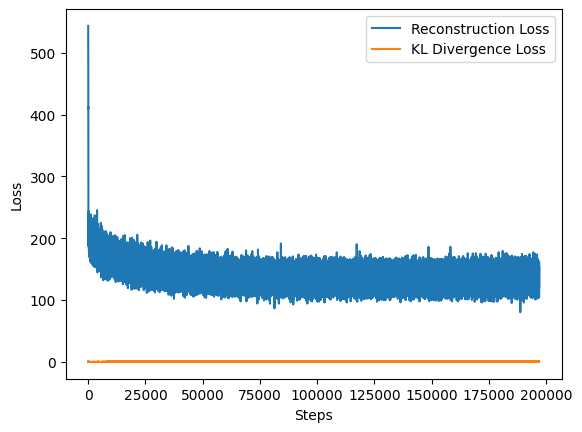

In [3]:

# Plot Losses
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


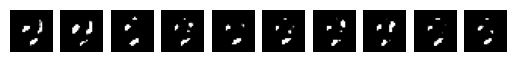

In [4]:
# Generation
def generate_samples(num_samples):
    with torch.no_grad():
        z = torch.rand(num_samples, categorical_dim * feature_dim)
        generated_samples = cvae.decoder(z)
        return generated_samples

generated_samples = generate_samples(10)
# Reshape and visualize the generated samples 
generated_samples = generated_samples.view(-1, 28, 28)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_samples[i], cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
# # get the number of classes
# classes = []
# for _, label in dataset:
#     if label not in classes:
#         classes.append(label)
# num_classes = len(classes)

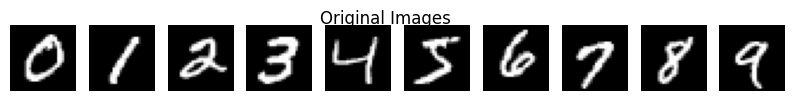

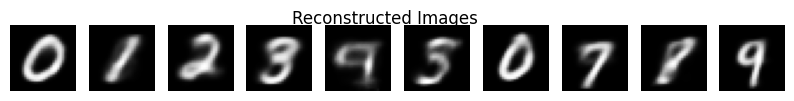

In [6]:
# Reconstruction from dataset
original_images = [None] * num_classes
reconstructed_images = [None] * num_classes

with torch.no_grad():
    for x, y in dataset:
        if all(img is not None for img in original_images):  # Check if we have collected all classes
            break
        if original_images[y] is not None:  # Skip if already collected for this class
            continue
        x = x.view(-1, input_dim)
        logits = cvae.encoder(x)
        z = gumbel_softmax(logits, temperature)
        x_recon = cvae.decoder(z)
        original_images[y] = x.view(28, 28).numpy()
        reconstructed_images[y] = x_recon.view(28, 28).numpy()

# Function to plot images
def plot_images(images, title):
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes, 1))
    for j, img in enumerate(images):
        axes[j].imshow(img, cmap='gray')
        axes[j].axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(original_images, 'Original Images')
plot_images(reconstructed_images, 'Reconstructed Images')


In [7]:
# categorize data by label

categorized_data = []
for i in range(10):
    for img, label in dataset:
        if label == i:
            categorized_data.append(img)
            break